### Experiments with training different dataset 

Goal is to see if training on high freq leads to better performance on low freq dataset than training on low freq dataset for high freq data  

8/19

Imports

In [1]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch.optim as optim
import heapq
import os
from datetime import datetime
import argparse
import torch.nn.functional as F

Set save to True if you want to save plots

In [2]:
save = False

Only for python script: uncomment if running on cluster

In [3]:
# These are both placeholders
num_epochs = 1000
model_name = 'f0'

In [4]:
plt.rcParams.update({
    'axes.titlesize': 30,     # Font size for titles
    'axes.labelsize': 30,     # Font size for x and y labels
    'xtick.labelsize': 20,    # Font size for x-axis tick labels
    'ytick.labelsize': 20,    # Font size for y-axis tick labels
    'legend.fontsize': 20,    # Font size for the legend
})

In [5]:
# # Parse command-line arguments
# parser = argparse.ArgumentParser(description='Train a neural network model')
# parser.add_argument('--epochs', type=int, default=1000, help='Number of training epochs')
# parser.add_argument('--model_name', type=str, default='model', help='Name of the saved model')
# args = parser.parse_args()

# # Use the parsed arguments
# num_epochs = args.epochs
# model_name = args.model_name

Check if CUDA is available

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [7]:
# For reproducibility
seed = 42

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(seed)

**Simplified function generation**

In [8]:
def generate_freq_dataset(num_samples, num_points, min_freq, max_freq):
    x = torch.linspace(0, 2 * np.pi, num_points, requires_grad=True)
    functions = []
    derivatives = []
    
    for _ in range(num_samples):
        # Fix maximum of 10 frequency components 
        num_freqs = torch.randint(1, 10, (1,)).item()
        amplitudes = torch.rand(num_freqs * 2)  # Double the number of amplitudes
        frequencies = torch.randint(min_freq, max_freq + 1, (num_freqs,)).float()
        phases = torch.rand(num_freqs * 2) * 2 * np.pi  # Double the number of phases
        
        y = sum(a * torch.sin(f * x + p) for a, f, p in zip(amplitudes[:num_freqs], frequencies, phases[:num_freqs])) + \
            sum(a * torch.cos(f * x + p) for a, f, p in zip(amplitudes[num_freqs:], frequencies, phases[num_freqs:]))
        
        dy_dx = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
        
        functions.append(y.detach().numpy())
        derivatives.append(dy_dx.detach().numpy())
    
    return np.array(functions), np.array(derivatives)

## Generate datasets

In [9]:
num_samples = 500
num_points = 1000
batch_size = 32

low_freq_functions, low_freq_derivatives = generate_freq_dataset(num_samples, num_points, 1, 5)
general_freq_functions, general_freq_derivatives = generate_freq_dataset(num_samples, num_points, 1, 15)
high_freq_functions, high_freq_derivatives = generate_freq_dataset(num_samples, num_points, 10, 15)

low_freq_dataset = TensorDataset(torch.tensor(low_freq_functions), torch.tensor(low_freq_derivatives))
general_freq_dataset = TensorDataset(torch.tensor(general_freq_functions), torch.tensor(general_freq_derivatives))
high_freq_dataset = TensorDataset(torch.tensor(high_freq_functions), torch.tensor(high_freq_derivatives))

low_freq_dataloader = DataLoader(TensorDataset(torch.tensor(low_freq_functions), torch.tensor(low_freq_derivatives)), batch_size=batch_size, shuffle=True)
high_freq_dataloader = DataLoader(TensorDataset(torch.tensor(high_freq_functions), torch.tensor(high_freq_derivatives)), batch_size=batch_size, shuffle=True)
general_freq_dataloader = DataLoader(TensorDataset(torch.tensor(general_freq_functions), torch.tensor(general_freq_derivatives)), batch_size=batch_size, shuffle=True)

In [10]:
total_size = len(low_freq_dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size
generator = torch.Generator().manual_seed(seed)

# low freq
train_dataset_l, test_dataset_l = random_split(low_freq_dataset, [train_size, test_size], generator=generator)
train_dataloader_l = DataLoader(train_dataset_l, batch_size=32, shuffle=True, drop_last=True)
test_dataloader_l = DataLoader(test_dataset_l, batch_size=32, shuffle=False, drop_last=True)

# general freq
train_dataset_g, test_dataset_g = random_split(general_freq_dataset, [train_size, test_size], generator=generator)
train_dataloader_g = DataLoader(train_dataset_g, batch_size=32, shuffle=True, drop_last=True)
test_dataloader_g = DataLoader(test_dataset_g, batch_size=32, shuffle=False, drop_last=True)

# high freq
train_dataset_h, test_dataset_h = random_split(high_freq_dataset, [train_size, test_size], generator=generator)
train_dataloader_h = DataLoader(train_dataset_h, batch_size=32, shuffle=True, drop_last=True)
test_dataloader_h = DataLoader(test_dataset_h, batch_size=32, shuffle=False, drop_last=True)


## Plot random function from one of the datasets

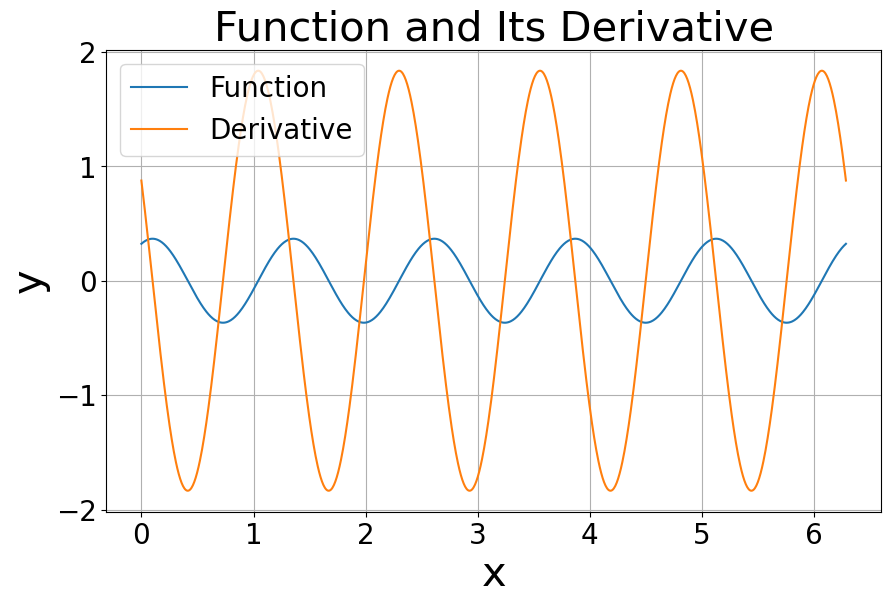

In [11]:
a = np.random.randint(32)

fun, deriv = next(iter(low_freq_dataloader))

first_function = fun[a]
first_derivative = deriv[a]

# Generate x values corresponding to the function inputs
x_values = np.linspace(0, 2 * np.pi, 1000)

# Plotting the function and its derivative
plt.figure(figsize=(10, 6))
plt.plot(x_values, first_function, label='Function')
plt.plot(x_values, first_derivative, label='Derivative')
plt.title('Function and Its Derivative')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# Save datasets
# torch.save(general_freq_dataset, 'datasets/general_freq_dataset.pt')
# torch.save(low_freq_dataset, 'datasets/low_freq_dataset.pt')
# torch.save(high_freq_dataset, 'datasets/high_freq_dataset.pt')

Stopped here

## Model architecture

This CNN uses 3 layers, each with kernel size 3

In [13]:
# simple 1D CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(64, 1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [14]:
f0 = SimpleCNN()
criterion = nn.MSELoss()

## Miscellaneous plotting functions

In [15]:
def plot_losses(train_losses, test_losses, save_dir='plots', filename=None, save=False):
    if not train_losses:
        return
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    current_date = datetime.now().strftime("%m-%d")
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, linestyle='-', color='b', label='Training Loss')
    plt.plot(epochs, test_losses, linestyle='-', label='Test Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')  # Set the y-axis to logarithmic scale
    plt.legend()
    # plt.grid(True)
    filename = f"{filename}_{current_date}.png"
    save_path = os.path.join(save_dir, filename)
    if save:
        plt.savefig(save_path)    
    plt.show()

In [16]:
def plot_output(model1, dataset, order=None, save_dir='plots', filename=None, save=False): 
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    current_date = datetime.now().strftime("%m-%d")
    model1.eval()  # Set the model to evaluation mode

    train_dataloader_viz = get_random_function(dataset, shuffle=True)
    # Get a random sample from the dataloader
    dataiter = iter(train_dataloader_viz)
    function, true_derivative = next(dataiter)

    # Reshape the input for the model
    function = function.unsqueeze(1)  # Add channel dimension

    # Make prediction
    with torch.no_grad():
        if order == 1 or order == 2:
            predicted_derivative = model1(function)
        
        if order == 'rollout':
            predicted_derivative = model1(function)
            predicted_derivative = model1(predicted_derivative)

    # Convert tensors to numpy arrays for plotting
    x = torch.linspace(0, 2*torch.pi, 1000).numpy()
    function = function.squeeze().numpy()

    predicted_derivative = predicted_derivative.squeeze().numpy()

    true_derivative = true_derivative.squeeze().numpy()

    # Plot the results
    plt.figure(figsize=(12, 6))

    plt.plot(x, function, label='Original Function', color='blue')
    if order == 1:
        plt.plot(x, true_derivative, label=f'True {order}st derivative')

    plt.plot(x[10:-10], predicted_derivative[10:-10], label=f'Predicted {order}nd Derivative', linestyle='--')

    plt.title('Function, True Derivatives, and Predicted Derivatives')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    # plt.grid(True)
    filename = f"{filename}_{current_date}.png"

    save_path = os.path.join(save_dir, filename)
    if save:
        plt.savefig(save_path)  
    plt.show()

In [17]:
def get_random_function(dataset, shuffle=True):
    return DataLoader(dataset, batch_size=1, shuffle=shuffle)

## Function to train model

In [18]:
train_losses, test_losses = [], []

def model_training(model, train_dataloader, test_dataloader, num_epochs,\
    split_freq=None, filename=None, save=None, order=None, nmse=None):
    train_losses = []
    test_losses = []

    low_freq_nmses = []
    general_freq_nmses = []
    high_freq_nmses = []
    epoch_list = []

    lr = 1e-3

    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Define a new loss function that can use NMSE
    def criterion2(target, output, nmse=None):
        mse = torch.mean((target - output) ** 2)
        if nmse:
            mse = mse / torch.mean(target ** 2)
        
        return mse

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        test_loss = 0.0

        for batch_functions, batch_derivatives in train_dataloader:
            batch_functions = batch_functions.unsqueeze(1)
            batch_derivatives = batch_derivatives.unsqueeze(1)

            outputs = model(batch_functions)
            loss = criterion2(outputs, batch_derivatives, nmse=nmse)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)

        
        # l, g, h = print_and_store_metrics(model, nmse=nmse)
        epoch_list.append(epoch)

        l, g, h = compute_mse(model, criterion2, optimizer, nmse=True)
        low_freq_nmses.append(l)
        general_freq_nmses.append(g)
        high_freq_nmses.append(h)
        print(f"The metrics are: {l}, {g}, and {h}")

        model.eval()
        with torch.no_grad():
            for b_test_functions, b_test_derivatives in test_dataloader:
                b_test_functions = b_test_functions.unsqueeze(1)
                b_test_derivatives = b_test_derivatives.unsqueeze(1)

                test_outputs = model(b_test_functions)
                batch_test_loss = criterion2(test_outputs, b_test_derivatives, nmse=True)

                test_loss += batch_test_loss.item()

        test_loss /= len(test_dataloader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

    print(f"Training finished for {order}st derivative")

    if nmse:
        loss_function = "NMSE"
    else:
        loss_function = "MSE"

    plt.figure(figsize=(10, 6))
    plt.plot(epoch_list, low_freq_nmses, label=f'Low frequency NMSE')
    plt.plot(epoch_list, general_freq_nmses, label=f'General frequency NMSE')
    plt.plot(epoch_list, high_freq_nmses, label=f'High frequency NMSE')

    # Adding labels and title
    plt.xlabel('Epoch')
    plt.ylabel('NMSE')
    plt.yscale('log')

    plt.title(f'Training Loss using {loss_function}')
    plt.legend()

    # Show the plot
    # plt.grid(True)
    plt.show()
    if save:
        plt.savefig(filename)  

    return train_losses, test_losses

## Metric functions

In [19]:
# def compute_mse(dataloader, model):
#     """
#     Takes in a dataloader and a model to compute MSE.
#     """

#     model.eval()
#     all_outputs = []
#     all_targets = []

#     for function, deriv in dataloader:
#         function = function.unsqueeze(1)
#         deriv = deriv.unsqueeze(1)

#         # Compute model output
#         model_output = model(function)
#         all_targets.append(deriv)

#         # Collect outputs
#         all_outputs.append(model_output)

#     # Concatenate all collected outputs and targets
#     all_outputs = torch.cat(all_outputs, dim=0)
#     all_targets = torch.cat(all_targets, dim=0)

#     # Compute MSE
#     mse = torch.mean((all_targets - all_outputs) ** 2)
#     nmse = mse / torch.mean(all_targets ** 2)

#     return mse.item(), nmse.item()

In [20]:
def compute_mse(model, criterion2, optimizer, nmse=True):
    test_loss_g = 0.0
    test_loss_l = 0.0
    test_loss_h = 0.0

    def criterion2(target, output, nmse=nmse):
        mse = torch.mean((target - output) ** 2)
        if nmse:
            mse = mse / torch.mean(target ** 2)
        
        return mse

    for batch_functions, batch_derivatives in test_dataloader_g:
        batch_functions = batch_functions.unsqueeze(1)
        batch_derivatives = batch_derivatives.unsqueeze(1)

        outputs = model(batch_functions)
        loss = criterion2(outputs, batch_derivatives, nmse=nmse)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        test_loss_g += loss.item()
    test_loss_g /= len(test_dataloader_g)

    for batch_functions, batch_derivatives in test_dataloader_l:
        batch_functions = batch_functions.unsqueeze(1)
        batch_derivatives = batch_derivatives.unsqueeze(1)

        outputs = model(batch_functions)
        loss = criterion2(outputs, batch_derivatives, nmse=nmse)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        test_loss_l += loss.item()
    test_loss_l /= len(test_dataloader_l)

    for batch_functions, batch_derivatives in test_dataloader_h:
        batch_functions = batch_functions.unsqueeze(1)
        batch_derivatives = batch_derivatives.unsqueeze(1)

        outputs = model(batch_functions)
        loss = criterion2(outputs, batch_derivatives, nmse=nmse)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        test_loss_h += loss.item()
    test_loss_h /= len(test_dataloader_h)
    
    return test_loss_l, test_loss_g, test_loss_h

In [21]:
def print_and_store_metrics(f0, nmse=False):
    if nmse:
        return compute_mse(train_dataloader_l, f0)[1], compute_mse(train_dataloader_g, f0)[1], compute_mse(train_dataloader_h, f0)[1]
    else:
        return compute_mse(train_dataloader_l, f0)[0], compute_mse(train_dataloader_g, f0)[0], compute_mse(train_dataloader_h, f0)[0]

In [22]:
def print_metrics(model):
    print(f"NMSE over low freq test functions: {compute_mse(test_dataloader_l, model)[1]}")
    print(f"NMSE over general freq test functions: {compute_mse(test_dataloader_g, model)[1]}")
    print(f"NMSE over high freq test functions: {compute_mse(test_dataloader_h, model)[1]}")



## Create models

In [23]:
# simple 1D CNN
class SimpleCNN(nn.Module):
    def __init__(self, n_layers=3, kernel_size=3, hidden_size=64):
        super(SimpleCNN, self).__init__()
        # Parameters
        self.n_layers = n_layers
        self.kernel_size = kernel_size
        self.hidden_size = hidden_size

        # Model
        self.convs = nn.ModuleList()
        if n_layers == 1:
            self.convs.append(nn.Conv1d(1, 1, kernel_size=kernel_size, padding=kernel_size//2))
        elif n_layers >= 2:
            self.convs.append(nn.Conv1d(1, hidden_size, kernel_size=kernel_size, padding=kernel_size//2))
            for _ in range(n_layers - 2):
                self.convs.append(nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_size, padding=kernel_size//2))
            self.convs.append(nn.Conv1d(hidden_size, 1, kernel_size=kernel_size, padding=kernel_size//2))
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        for i, conv in enumerate(self.convs):
            if i < len(self.convs) - 1:
                x = self.relu(conv(x))
            else:
                x = conv(x)
        return x

In [24]:
set_seed(seed)
L3ModelK3 = SimpleCNN(n_layers=3, kernel_size=3)

## Plot results

In [25]:
def plot_all_outputs(model, model_name):
    plot_output(model, dataset=test_dataset_l, order=1, save_dir='../plots/spectral_bias', filename=f'{model_name}_E{num_epochs}_lf_output', save=save)
    plot_output(model, dataset=test_dataset_g, order=1, save_dir='../plots/spectral_bias', filename=f'{model_name}_E{num_epochs}_lf_output', save=save)
    plot_output(model, dataset=test_dataset_h, order=1, save_dir='../plots/spectral_bias', filename=f'{model_name}_E{num_epochs}_lf_output', save=save)

## Color map plots

In [26]:
def compute_fft_and_max_freq(dataloader, deriv=False, model=None, residue=False):
    fft_amplitudes = []
    max_frequencies = []
    T = 2 * torch.pi
    N = 1000

    # Calculate frequencies for the FFT
    frequencies = torch.fft.fftfreq(N, T / (2 * torch.pi * N))
    positive_freq_indices = frequencies >= 0
    positive_freqs = frequencies[positive_freq_indices]

    # Iterate over each batch
    for functions, derivatives in dataloader:  # Note that derivatives are ignored in this loop
        
        if deriv and not model: # If deriv is true and model is none then use derivatives
            functions = derivatives
            
        if not deriv and model and not residue: # If deriv is false and model is entered then compute derivative
            functions = model(functions.unsqueeze(1)).squeeze()
            # output = model(functions)
            
            # output = output.squeeze()
            # functions = output # set this so that the FFTs can be computed in the next line
        
        elif residue and model:
            print("computing residue")
            outputs = model(functions.unsqueeze(1)).squeeze()
            residues = derivatives - outputs
            norm_residues = residues / derivatives
            functions = norm_residues

        # Compute FFT using PyTorch
        F = torch.fft.fft(functions)
        magnitudes = torch.abs(F) / N

        # Consider only positive frequencies
        positive_magnitudes = magnitudes[:, positive_freq_indices]

        fft_amplitudes.append(positive_magnitudes)
        
        # Maximum frequency based on the highest amplitude for each function in the batch
        max_indices = torch.argmax(positive_magnitudes, dim=1)
        batch_max_freqs = positive_freqs[max_indices]
        max_frequencies.extend(batch_max_freqs)

    return torch.vstack(fft_amplitudes), torch.tensor(max_frequencies), positive_freqs

def plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type, xmin=0, xmax=0):
    fft_amplitudes = fft_amplitudes.detach().numpy()
    max_frequencies = max_frequencies.detach().numpy()
    freqs = freqs.detach().numpy()
    
    # Sort functions by the maximum frequency
    sorted_indices = np.argsort(-max_frequencies)  # Sort in descending order
    sorted_fft = fft_amplitudes[sorted_indices]

    plt.figure(figsize=(10, 6))
    im = plt.imshow(sorted_fft, aspect='auto', extent=[freqs[0], freqs[-1], 0, len(sorted_fft)],\
        interpolation='nearest')
    plt.colorbar(im, label='Amplitude')
    plt.xlabel('Frequency (rad/s)')
    plt.ylabel('Function Index (sorted by max frequency)')
    plt.title(f'FFT Amplitude Heatmap for {fun_type}')
    plt.xlim([xmin, xmax])
    plt.show()


In [27]:
# Default is u_g
# This function plots the heatmaps for all frequencies for the test datlaoaders
def plot_heatmaps(deriv=None, model=None, residue=False, label=None):
    fft_amplitudes, max_frequencies, freqs = compute_fft_and_max_freq(test_dataloader_l,\
        deriv=deriv, model=model, residue=residue)
    plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type=f'Low freq {label}', xmin=0, xmax=6)

    fft_amplitudes, max_frequencies, freqs = compute_fft_and_max_freq(test_dataloader_g,\
        deriv=deriv, model=model, residue=residue)
    plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type=f'General freq {label}', xmin=0, xmax=16)

    fft_amplitudes, max_frequencies, freqs = compute_fft_and_max_freq(test_dataloader_h,\
        deriv=deriv, model=model, residue=residue)
    plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type=f'High freq {label}', xmin=10, xmax=16)


In [28]:
# plot_heatmaps(label='u_g')

## Experiments with training on different datasets

3 layers, kernel size 3

TRAINING OVER DIFFERENT RANDOM SEEDS

In [36]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

def model_training(model, train_dataloader, test_dataloader, num_epochs, split_freq=None, filename=None, save=None, order=None, nmse=None, seed=None):
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)

    train_losses = []
    test_losses = []
    low_freq_nmses = []
    general_freq_nmses = []
    high_freq_nmses = []
    epoch_list = []

    lr = 1e-3
    optimizer = optim.Adam(model.parameters(), lr=lr)

    def criterion2(target, output, nmse=None):
        mse = torch.mean((target - output) ** 2)
        if nmse:
            mse = mse / torch.mean(target ** 2)
        return mse

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        test_loss = 0.0

        for batch_functions, batch_derivatives in train_dataloader:
            batch_functions = batch_functions.unsqueeze(1)
            batch_derivatives = batch_derivatives.unsqueeze(1)

            outputs = model(batch_functions)
            loss = criterion2(outputs, batch_derivatives, nmse=nmse)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)

        epoch_list.append(epoch)

        l, g, h = compute_mse(model, criterion2, optimizer, nmse=True)
        low_freq_nmses.append(l)
        general_freq_nmses.append(g)
        high_freq_nmses.append(h)

        model.eval()
        with torch.no_grad():
            for b_test_functions, b_test_derivatives in test_dataloader:
                b_test_functions = b_test_functions.unsqueeze(1)
                b_test_derivatives = b_test_derivatives.unsqueeze(1)

                test_outputs = model(b_test_functions)
                batch_test_loss = criterion2(test_outputs, b_test_derivatives, nmse=True)

                test_loss += batch_test_loss.item()

        test_loss /= len(test_dataloader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

    return train_losses, test_losses, low_freq_nmses, general_freq_nmses, high_freq_nmses

def run_multiple_seeds(train_dataloader, test_dataloader, num_epochs, seeds, split_freq=None, filename=None, save=None, order=None, nmse=None):
    all_train_losses = []
    all_test_losses = []
    all_low_freq_nmses = []
    all_general_freq_nmses = []
    all_high_freq_nmses = []

    for seed in seeds:
        set_seed(seed)
        model = SimpleCNN(n_layers=3, kernel_size=3)

        train_losses, test_losses, low_freq_nmses, general_freq_nmses, high_freq_nmses = model_training(
            model, train_dataloader, test_dataloader, num_epochs, split_freq, filename, save, order, nmse, seed
        )
        all_train_losses.append(train_losses)
        all_test_losses.append(test_losses)
        all_low_freq_nmses.append(low_freq_nmses)
        all_general_freq_nmses.append(general_freq_nmses)
        all_high_freq_nmses.append(high_freq_nmses)

    return all_train_losses, all_test_losses, all_low_freq_nmses, all_general_freq_nmses, all_high_freq_nmses

def plot_results(all_low_freq_nmses, all_general_freq_nmses, all_high_freq_nmses, num_epochs, loss_function, filename=None, save=None):
    epoch_list = list(range(num_epochs))

    plt.figure(figsize=(10, 6))

    for data, label in zip([all_low_freq_nmses, all_high_freq_nmses], # removed general frequency
                           ['Low frequency NMSE', 'High frequency NMSE']):
        mean = np.mean(data, axis=0)
        std_err = np.std(data, axis=0) / np.sqrt(len(data))

        plt.plot(epoch_list, mean, label=label)
        plt.fill_between(epoch_list, mean - std_err, mean + std_err, alpha=0.3)

    plt.xlabel('Epoch')
    plt.ylabel('NMSE')
    plt.yscale('log')
    plt.title(f'Training Loss using {loss_function}')
    plt.legend()

    if save:
        plt.savefig(filename)
    plt.show()


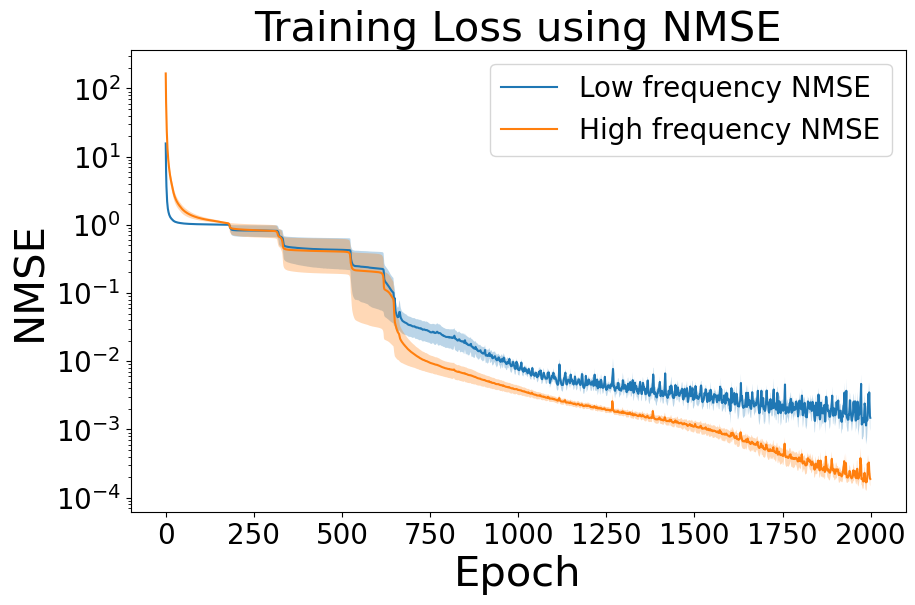

In [39]:
# set_seed(seed)
# L3ModelK3_low = SimpleCNN(n_layers=3, kernel_size=3)

# Main execution
seeds = [1, 2, 3, 4, 5]
num_epochs = 2000  # Adjust as needed

all_train_losses, all_test_losses, all_low_freq_nmses, all_general_freq_nmses, all_high_freq_nmses = run_multiple_seeds(
    # L3ModelK3_low, train_dataloader_g, test_dataloader_g, num_epochs, seeds, nmse=False
    train_dataloader_g, test_dataloader_g, num_epochs, seeds, nmse=True
)

plot_results(all_low_freq_nmses, all_general_freq_nmses, all_high_freq_nmses, num_epochs, "NMSE", filename="nmse_plot.png", save=True)

### Training on general frequency dataset only

In [31]:
set_seed(seed)
L3ModelK3_low = SimpleCNN(n_layers=3, kernel_size=3)

train_losses, test_losses = model_training(L3ModelK3_low, train_dataloader_g, test_dataloader_g,\
    num_epochs=2000, split_freq=1, filename='../plots/spectral_bias/f0_E2000_phased_training',\
    save=save, order='first', nmse=True)
plot_losses(train_losses, test_losses, save_dir='../plots/spectral_bias', filename='f0_E2000_phased_training', save=save)

KeyboardInterrupt: 

### Using MSE instead of NMSE for training

In [31]:
set_seed(seed)
L3ModelK3_low = SimpleCNN(n_layers=3, kernel_size=3)

train_losses, test_losses = model_training(L3ModelK3_low, train_dataloader_g, test_dataloader_g,\
    num_epochs=2000, split_freq=1, filename='../plots/spectral_bias/f0_E2000_phased_training',\
    save=save, order='first', nmse=False)
plot_losses(train_losses, test_losses, save_dir='../plots/spectral_bias', filename='f0_E2000_phased_training', save=save)

The metrics are: 67.76434707641602, 2515.4547526041665, and 359.87697347005206
Epoch [1/2000], Train Loss: 143.5308, Test Loss: 132.8331
The metrics are: 7.21807066599528, 51.83710861206055, and 77.6314926147461
Epoch [2/2000], Train Loss: 143.9456, Test Loss: 38.3470
The metrics are: 4.737960497538249, 29.7270991007487, and 48.9631462097168
Epoch [3/2000], Train Loss: 148.0793, Test Loss: 24.5107
The metrics are: 3.6069489320119223, 20.603495279947918, and 35.29757817586263
Epoch [4/2000], Train Loss: 147.1393, Test Loss: 18.0428
The metrics are: 3.134800831476847, 16.692273139953613, and 29.65964635213216
Epoch [5/2000], Train Loss: 147.8933, Test Loss: 15.4108
The metrics are: 2.9550161361694336, 15.251157760620117, and 27.29354413350423
Epoch [6/2000], Train Loss: 149.5857, Test Loss: 14.1970
The metrics are: 2.900189161300659, 14.669439315795898, and 26.831218719482422
Epoch [7/2000], Train Loss: 150.3215, Test Loss: 14.0647
The metrics are: 2.8945343494415283, 14.639824867248535,

The metrics are: 2.893608013788859, 12.911405881245932, and 19.50047429402669
Epoch [25/2000], Train Loss: 130.4098, Test Loss: 10.2231
The metrics are: 2.96793802579244, 12.842650095621744, and 18.638694763183594
Epoch [26/2000], Train Loss: 126.3994, Test Loss: 10.0322
The metrics are: 3.2862680753072104, 13.715038299560547, and 18.106032689412434
Epoch [27/2000], Train Loss: 124.2795, Test Loss: 10.0898
The metrics are: 3.286524852116903, 12.352684338887533, and 16.168738683064777
Epoch [28/2000], Train Loss: 115.5057, Test Loss: 10.0704
The metrics are: 3.2755469481150308, 10.891847928365072, and 13.361158688863119
Epoch [29/2000], Train Loss: 108.3926, Test Loss: 9.3364
The metrics are: 3.143996477127075, 8.87634531656901, and 10.1432523727417
Epoch [30/2000], Train Loss: 98.5416, Test Loss: 7.7220
The metrics are: 2.8217102686564126, 6.654412428538005, and 7.2952728271484375
Epoch [31/2000], Train Loss: 91.3347, Test Loss: 5.9124
The metrics are: 2.444009780883789, 4.736306985219

KeyboardInterrupt: 

## IGNORE BELOW, 9/3

### Questions:
- Does training on high freq data lead to better performance on low freq data, or vice-versa? I.e., is the performance delta larger or smaller? 
    - Yes: training on high freq data leads to a smaller performance gap on the low freq data than vice-versa.
    - However, training on the general freq dataset leads to the best performance overall, **but there is a an opposite bias for some reason: high freq data has lower NMSE than low freq data, which is counterintuitive**
    - And, the general freq NMSE is almost identical to the high freq NMSE
- Need to plot the heatmap over epochs
- Is this happening because the **MSE** is larger for high freq data and therefore learning that better?
- Does changing the model architecture (layers or kernel size) change this bias?
- Can "fine-tuning" a model that was trained on high freq data with low freq data lead to better performance than just training on general freq?